## **Rock Paper Scissors Transfer leanring**

In this notebook you will use the transer learning method to allow a neural network to recognize your hand and sign when you play Rock Paper Scissors.

In order to run this notebook **you must to import** both train dataset (https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip) and test dataset (https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip).

Once you have them, you must put them in the dataset folder, you must have this hierarchy:

* dataset
    - Test
        - paper
        - rock
        - scissors
    - Train
        - paper
        - rock
        - scissors


In [1]:
import numpy as np
import time
import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

If you want to modify the path to your datasets, change this cell.

In [2]:
dataset_train = "dataset/Train"
dataset_test = "dataset/Test"

This set the subfolders where you will store the downloaded resource.

In [3]:
keras_cache_dir = os.path.join(os.getcwd(),'keras_cache')
os.makedirs(keras_cache_dir, exist_ok = True)

tfhub_cache_dir = os.path.join(os.getcwd(),'tfhub_cache')
os.makedirs(tfhub_cache_dir, exist_ok = True)
os.environ['TFHUB_CACHE_DIR'] = tfhub_cache_dir

This cell loads the Train dataset in **80% a training set** and **20% a validation set** to verify that our model does not over fit.

It also loads the Test set.

In [4]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2520 files belonging to 3 classes.
Using 2016 files for training.
Found 2520 files belonging to 3 classes.
Using 504 files for validation.
Found 372 files belonging to 3 classes.


This defines an array that contains the class names

In [5]:
class_names = np.array(train_ds.class_names)
print(class_names)

['paper' 'rock' 'scissors']


Images need to be rescaled to be used by the model.

In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Then to increase the learning performance, images are pre-fetch. 

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

The training set is split to have images and labels fields for future use.

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Model used for transfer learning

We chose to use a **mobilenet model**, we needed to compress it to TF Lite format once it was trained.

We also chose the v2 to have better and faster result.

In [3]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

This cell loads the layers of the pre-trained model and **freeze all the weights** of the neurons.

In [10]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

And the layers are loaded in the model that will be trained.

In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Here is our configuration for the training process, you can tweak it you want.

It then compiles the model.

In [12]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

This cell trains the model on **20 epochs** on the training set and the validation sets.

You need to keep an eye on the results, if the validation accuracy/loss diverges too far from the training accuracy/loss, **the model is overfitting**.

If your model overfit, you can adrdress it by using data augmentation on the Train dataset.

In [13]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

    self.val_losses = []
    self.val_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

  def on_epoch_end(self, epoch, logs=None):
    self.val_losses.append(logs['val_loss'])
    self.val_acc.append(logs['val_acc'])
    self.model.reset_metrics()


batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=20, callbacks=[batch_stats_callback], validation_data=val_ds)

Epoch 1/20
63/63 [==============================] - 82s 1s/step - loss: 0.1085 - acc: 1.0000 - val_loss: 0.0943 - val_acc: 1.0000
Epoch 2/20
63/63 [==============================] - 67s 1s/step - loss: 0.0460 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 1.0000
Epoch 3/20
63/63 [==============================] - 66s 1s/step - loss: 0.0286 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 1.0000
Epoch 4/20
63/63 [==============================] - 66s 1s/step - loss: 0.0202 - acc: 1.0000 - val_loss: 0.0186 - val_acc: 1.0000
Epoch 5/20
63/63 [==============================] - 67s 1s/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 1.0000
Epoch 6/20
63/63 [==============================] - 67s 1s/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 7/20
63/63 [==============================] - 67s 1s/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 8/20
63/63 [==============================] - 67s 1s/step - loss: 0.0075 - acc: 1.00

Those cell will print accuracy/loss graphs for both training set and validation set.

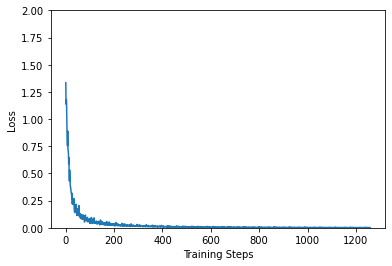

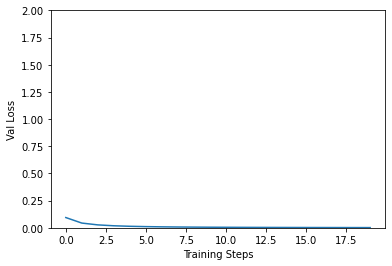

In [14]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses);

plt.figure()
plt.ylabel("Val Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.val_losses);

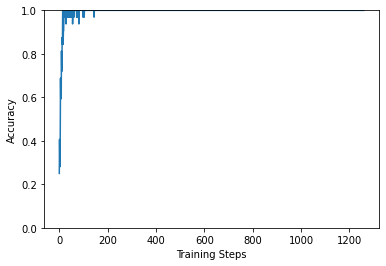

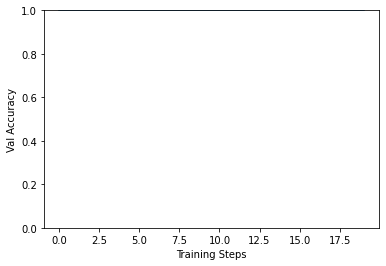

In [15]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc);

plt.figure()
plt.ylabel("Val Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.val_acc);

This saves the trained model, you can change the export path if needed.

In [16]:
t = time.time()

export_path = f"saved_models/model_1"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/model_1/assets
INFO:tensorflow:Assets written to: saved_models/model_1/assets


'saved_models/model_1'

The testing set is split to have images and labels fields for future use.

In [17]:
for image_batch_test, labels_batch_test in test_ds:
  print(image_batch_test.shape)
  print(labels_batch_test.shape)
  break

(32, 224, 224, 3)
(32,)


This cell calls the model to make predictions and be evaluated on the testing set.

In [18]:
predicted_batch = model.predict(image_batch_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

evalutation_result = model.evaluate(image_batch_test, labels_batch_test, batch_size=batch_size)

1/1 [==============================] - 2s 2s/step - loss: 0.3431 - acc: 0.7812


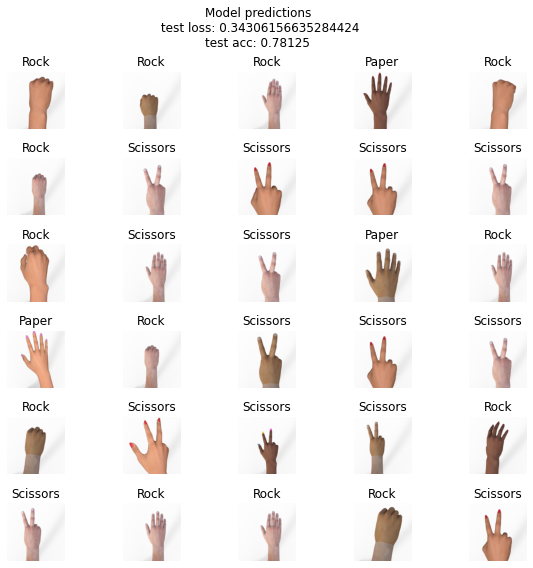

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions\n test loss: " + str(evalutation_result[0]) + "\ntest acc: " + str(evalutation_result[1]))

The model achieves an accuracy of **0.78**, this is not really good.

This is as high as it will get without some data augmentation and more epochs.

## Fine-tuning

The following code will try to achieve a better accuracy by using fine-tuning.

It unfreezes the layers weights and the trained model is compile once again with this time a very low learning rate

In [20]:
feature_extractor_layer.trainable = True

model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-5),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

It is then trained on both training and validation set.

Because it takes 8 times longer with unfrozen weights, its only trained for 10 epochs.

In [21]:
history = model.fit(train_ds, epochs=10, callbacks=[batch_stats_callback], validation_data=val_ds)

Epoch 1/10
63/63 [==============================] - 417s 6s/step - loss: 0.1653 - acc: 0.9688 - val_loss: 0.2828 - val_acc: 0.9167
Epoch 2/10
63/63 [==============================] - 406s 6s/step - loss: 0.0978 - acc: 1.0000 - val_loss: 0.2273 - val_acc: 0.9405
Epoch 3/10
63/63 [==============================] - 406s 6s/step - loss: 0.0912 - acc: 1.0000 - val_loss: 0.1343 - val_acc: 0.9762
Epoch 4/10
63/63 [==============================] - 405s 6s/step - loss: 0.0884 - acc: 1.0000 - val_loss: 0.1049 - val_acc: 0.9940
Epoch 5/10
63/63 [==============================] - 400s 6s/step - loss: 0.0869 - acc: 1.0000 - val_loss: 0.0923 - val_acc: 0.9980
Epoch 6/10
63/63 [==============================] - 403s 6s/step - loss: 0.0860 - acc: 1.0000 - val_loss: 0.0879 - val_acc: 1.0000
Epoch 7/10
63/63 [==============================] - 403s 6s/step - loss: 0.0854 - acc: 1.0000 - val_loss: 0.0863 - val_acc: 1.0000
Epoch 8/10
63/63 [==============================] - 406s 6s/step - loss: 0.0849 - a

Those cells will print accuracy/loss graphs for both training set and validation set.

The blue vertical bar is the delimitation between frozen weights and fine-tuning process.

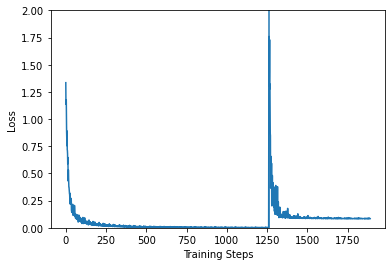

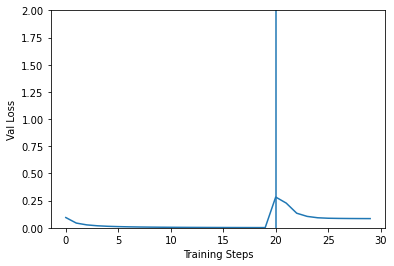

In [22]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.axvline(x=1260)
plt.plot(batch_stats_callback.batch_losses);
plt.ylim([0,2])
plt.axvline(x=1260)
plt.plot(batch_stats_callback.batch_losses);

plt.figure()
plt.ylabel("Val Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.axvline(x=20)
plt.plot(batch_stats_callback.val_losses);

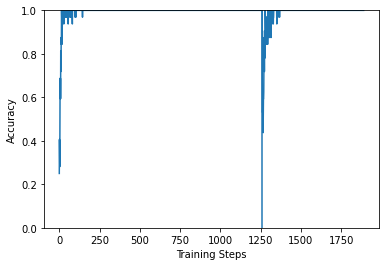

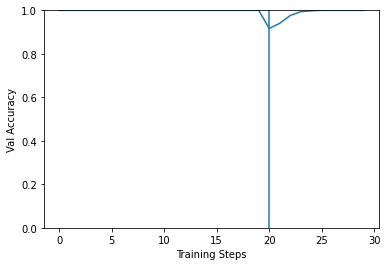

In [23]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.axvline(x=1260)
plt.plot(batch_stats_callback.batch_acc)

plt.figure()
plt.ylabel("Val Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.axvline(x=20)
plt.plot(batch_stats_callback.val_acc);

This cell calls the fine-tuned model to make predictions and be evaluated on the testing set.

In [24]:
predicted_batch = model.predict(image_batch_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

evalutation_result = model.evaluate(image_batch_test, labels_batch_test, batch_size=batch_size)

1/1 [==============================] - 1s 1s/step - loss: 0.2253 - acc: 0.9375


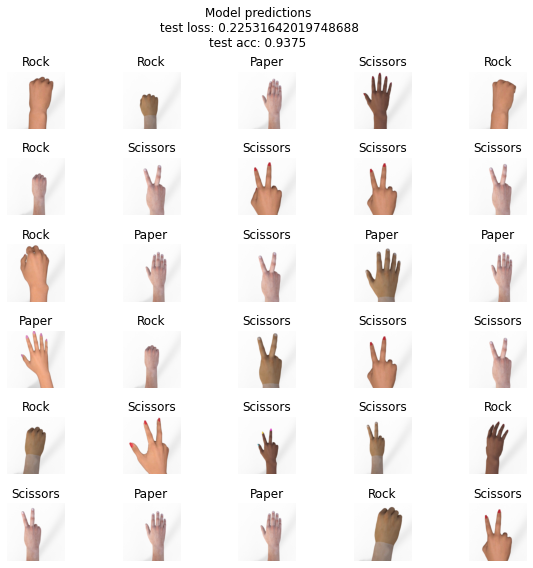

In [25]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions\n test loss: " + str(evalutation_result[0]) + "\ntest acc: " + str(evalutation_result[1]))

this save the fine-tuned model.

You can change the export_path if needed.

In [26]:
t = time.time()

export_path = f"saved_models/model_1_fine"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/model_1_fine/assets
INFO:tensorflow:Assets written to: saved_models/model_1_fine/assets


'saved_models/model_1_fine'

## Result

The fine-tune model has an **accuracy of 0.93**, this is a really good result.

This model will be used to be converted into a TF lite model.